In [2]:
# import
%pylab inline
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

Populating the interactive namespace from numpy and matplotlib


## Question 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:

Which are the best universities in term of:       
(a) ratio between faculty members and students,     
(b) ratio of international students?       
Answer the previous question aggregating the data by      
(c) country and     
(d) region.

Plot your data using bar charts and describe briefly what you observed.

We define some variables we will use several times in the code.    
We then simply use a request to get the main page.

In [3]:
TOP_COUNT = 200
fac_members = 'fac_members'
inter_fac_members = 'inter_fac_members'
students = 'students'
inter_students = 'inter_students'
ratio_inter_students = 'ratio_inter_students'
country = 'country'
region = 'region'
ratio_fac_students = 'ratio_fac_students'

top_uni_json_link = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508402735534"
r = requests.get(top_uni_json_link)

We define a function to retrieve the number of students / faculty members given an url, and one function to clean the rank datas (as you can have equals sign)

In [4]:
def retrieve_people_number(url):
    div = 'div'
    data_carousel = 'academic-data-carousel'
    complete_url = "https://www.topuniversities.com/" + url
    r = requests.get(complete_url)
    
    soup = BeautifulSoup(r.text, 'html.parser') #Parse using BeautifulSoup
    
    numbers = soup.find(div, {'id':data_carousel})
    if (numbers==None): #If we can't find the data, we skip it
        print("error at : " + url)
        return None
    
    numbers = numbers.find_all(div, class_='number')
    
    #We remove the comma in the numbers
    numbers = list(map(lambda x: int(x.contents[0].replace('\n', '').replace(',', '')), numbers)) 
    if(len(numbers) == 4): 
        return numbers
    else:
        #If there isn't enough data, we perform some additional steps
        print("wrong number of elements at : " + url)
        #We find the h3 tags and find which ones are available
        h3s = soup.find(div, {'id':data_carousel}).find_all('h3') 
        h3s = list(map(lambda x: (x.contents[0].replace('\n', '').replace(',', '')), h3s))
        labels = ['Number of academic faculty staff','International','Number of students','Number of international students']
                
        result = [np.nan, np.nan, np.nan, np.nan]
        for h in range(0, len(h3s)):
            idx = labels.index(h3s[h])
            result[idx] = numbers[h]
        
        return result
    
def clean_rank(df):
    df['rank'] = df['rank'].str.replace('=','').astype(int)
    
def plot_ranks(df, sort_column, row_numbers, title, x_axis, y_axis):
    if(row_numbers != -1):
        if(x_axis != ''):
            df[~pd.isnull(df[[sort_column]]).any(axis=1)].sort_values(sort_column, ascending=True).iloc[-row_numbers:]\
            .plot(title=title +": %d first" % row_numbers, legend=False,x=x_axis, y=y_axis, kind='barh')

            df[~pd.isnull(df[[sort_column]]).any(axis=1)].sort_values(sort_column, ascending=True).iloc[:row_numbers]\
            .plot(title=title+": %d last" % row_numbers, legend=False,x=x_axis, y=y_axis, kind='barh')
        else:
            df[~pd.isnull(df[[sort_column]]).any(axis=1)].sort_values(sort_column, ascending=True).iloc[-row_numbers:]\
            .plot(title=title +": %d first" % row_numbers, legend=False, y=y_axis, kind='barh')

            df[~pd.isnull(df[[sort_column]]).any(axis=1)].sort_values(sort_column, ascending=True).iloc[:row_numbers]\
            .plot(title=title+": %d last" % row_numbers, legend=False, y=y_axis, kind='barh')
    else:
        df[~pd.isnull(df[[sort_column]]).any(axis=1)].sort_values(sort_column, ascending=True)\
        .plot(title=title, legend=False, y=y_axis, kind='barh')



We then create the DataFrame using the data from the main page, then populate a new DataFrame by iterating in the original DataFrame and retrieving the details for each university

In [5]:
top_uni_df = pd.DataFrame(r.json()['data']).head(TOP_COUNT)

missing_datas = pd.DataFrame(columns=[fac_members,inter_fac_members,students,inter_students])
for index, row in top_uni_df.iterrows(): 
    tmp = retrieve_people_number(row.url)
    if(tmp != None):
        missing_datas.loc[index] = tmp
    else: 
        missing_datas.loc[index] = [np.nan, np.nan, np.nan, np.nan]


error at : /universities/new-york-university-nyu
wrong number of elements at : /universities/indian-institute-science-iisc-bangalore


We then simply concatenate them and calculate the ratio faculty members/students and international students/students. We then drop the columns we won't need anymore.

In [6]:
def agg_by_and_calculate_ratio(df, byS, second):
    df['nb_univ'] = 1
    if (second):
        df=df[[byS,fac_members,students,inter_students,'nb_univ']].groupby(by=[byS]).agg([sum])
    else:
        df=df[[byS,fac_members,inter_fac_members,students,inter_students,'nb_univ']].groupby(by=[byS]).agg([sum])
        
    df.columns = df.columns.get_level_values(0)
    return calculate_ratio(df)

def calculate_ratio(df):
    df[ratio_fac_students] = df[fac_members].values / df[students]
    df[ratio_inter_students] = df[inter_students].values / df[students]
    return df

In [7]:
top_uni_df_complete = pd.concat([top_uni_df, missing_datas], axis=1)
top_uni_df_complete.drop(['cc','core_id', 'guide','logo','nid','score','stars','url'], axis=1, inplace=True)

# rename columns for future computation
top_uni_df_complete.rename(columns={'title': 'University', 'rank_display': 'rank'}, inplace=True)

#clean the ranking column
clean_rank(top_uni_df_complete)

#compute the two asked ration
calculate_ratio(top_uni_df_complete)

top_uni_df_complete.head()

,country,rank,region,University,fac_members,inter_fac_members,students,inter_students,ratio_fac_students,ratio_inter_students
0,United States,1,North America,Massachusetts Institute of Technology (MIT),2982,1679,11067,3717,0.26945,0.335863
1,United States,2,North America,Stanford University,4285,2042,15878,3611,0.26987,0.227422
2,United States,3,North America,Harvard University,4350,1311,22429,5266,0.193945,0.234785
3,United States,4,North America,California Institute of Technology (Caltech),953,350,2255,647,0.422616,0.286918
4,United Kingdom,5,Europe,University of Cambridge,5490,2278,18770,6699,0.292488,0.356899


We expect the USA and UK to have a big ratio of international students. We don't really have expectations for faculty members.

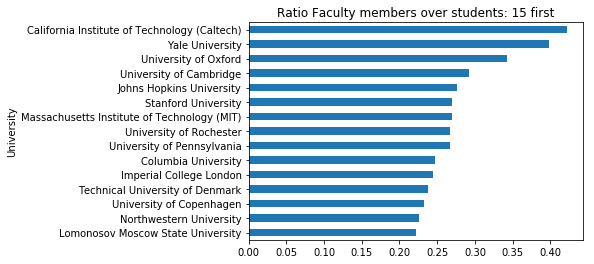

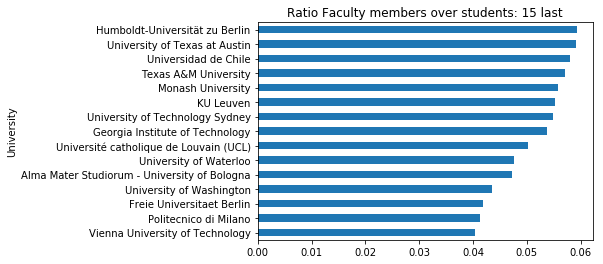

In [8]:
plot_ranks(top_uni_df_complete, ratio_fac_students, 15, \
           'Ratio Faculty members over students', 'University','ratio_fac_students')   

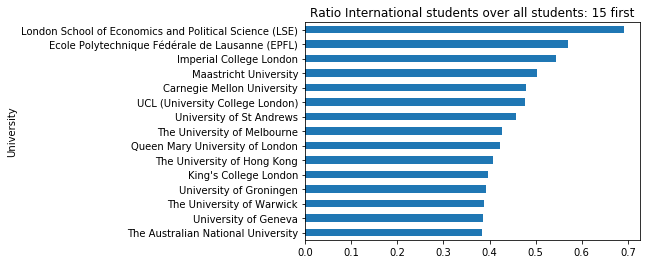

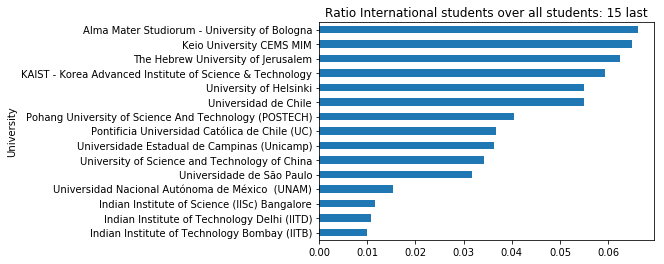

In [9]:
plot_ranks(top_uni_df_complete, ratio_inter_students, 15, \
           'Ratio International students over all students', 'University','ratio_inter_students')   

Our assumption is mostly true, as 3 in the top 5 are universities from UK or USA. Also, EPFL is second place with 57% of international students.

We then aggregate by country, and then by region. We recalculate the ratios using the aggregated numbers, instead of doing a mean on the ratios (as that would be false, given that a small university could have a big ratio but shouldn't have a big impact on the total.)

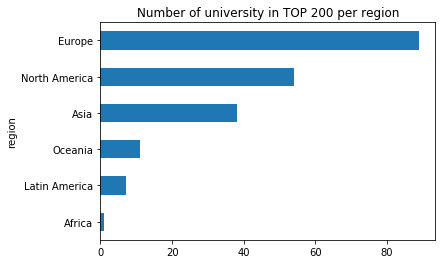

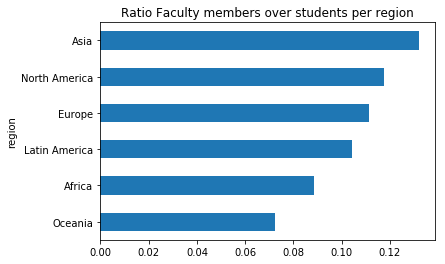

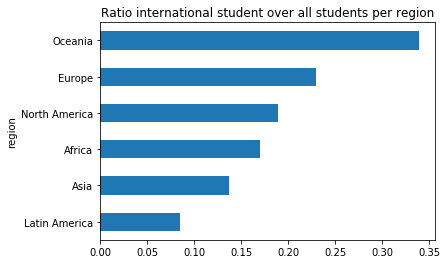

In [10]:
top_uni_df_complete_region = agg_by_and_calculate_ratio(top_uni_df_complete, region, False)

plot_ranks(top_uni_df_complete_region, 'nb_univ', -1, \
           'Number of university in TOP 200 per region', '','nb_univ')   

plot_ranks(top_uni_df_complete_region, ratio_fac_students, -1, \
           'Ratio Faculty members over students per region', '','ratio_fac_students')   

plot_ranks(top_uni_df_complete_region, ratio_inter_students, -1, \
           'Ratio international student over all students per region', '','ratio_inter_students')   

As expected, Europe and North America are in top 3, but Oceania is far ahead with 34%, which we didn't expect. That should be mostly due to Australia.

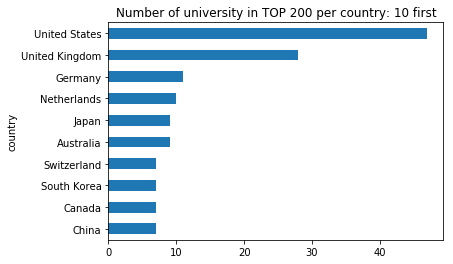

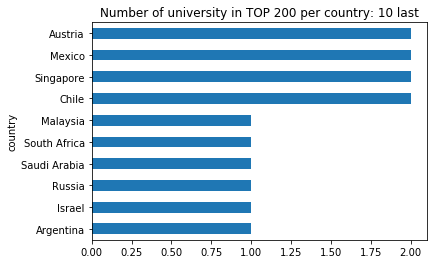

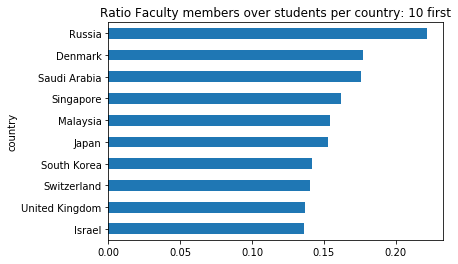

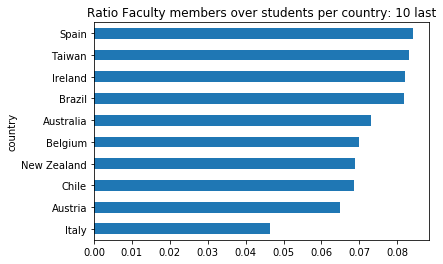

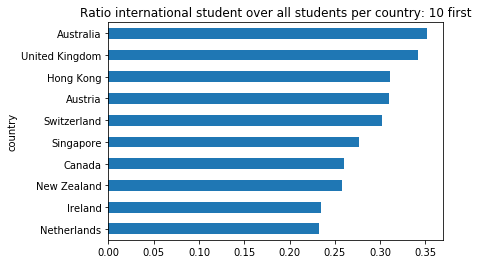

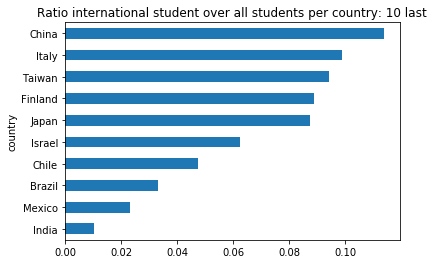

In [11]:
top_uni_df_complete_country = agg_by_and_calculate_ratio(top_uni_df_complete,country,False)

plot_ranks(top_uni_df_complete_country, 'nb_univ', 10, \
           'Number of university in TOP 200 per country', '','nb_univ') 

plot_ranks(top_uni_df_complete_country, ratio_fac_students, 10, \
           'Ratio Faculty members over students per country', '','ratio_fac_students')  

plot_ranks(top_uni_df_complete_country, ratio_inter_students, 10, \
           'Ratio international student over all students per country', '','ratio_inter_students')   

Indeed, looking at the ratio for international students, Australia is in first place. UK is close second, as expected, but USA is quite far down, which is a surprise. That's probably due to the difficulty to be accepted without an existing deal between an USA university and another. Switzerland is also notably fifth on the list.

## Question 2
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

We simply repeat the same process, although we don't have to make other requests to obtain the details.

In [12]:
stats_student_staff_ratio = 'stats_student_staff_ratio'
title_s = 'University'
times_high_json_link = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
r = requests.get(times_high_json_link)

In [13]:
times_high_df = pd.DataFrame(r.json()['data']).head(TOP_COUNT)

times_high_df = times_high_df[['location','aliases','name','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]

# clean rank column
clean_rank(times_high_df)

times_high_df.head()

,location,aliases,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United Kingdom,University of Oxford,University of Oxford,1,"20,409",38%,11.2
1,United Kingdom,University of Cambridge,University of Cambridge,2,"18,389",35%,10.9
2,United States,California Institute of Technology caltech,California Institute of Technology,3,"2,209",27%,6.5
3,United States,Stanford University,Stanford University,3,"15,845",22%,7.5
4,United States,Massachusetts Institute of Technology,Massachusetts Institute of Technology,5,"11,177",34%,8.7


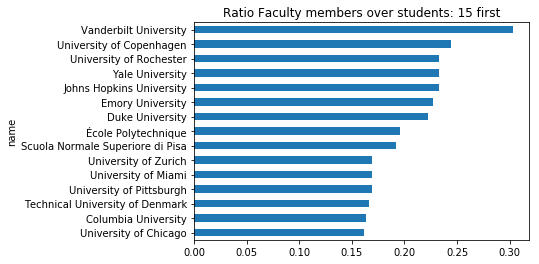

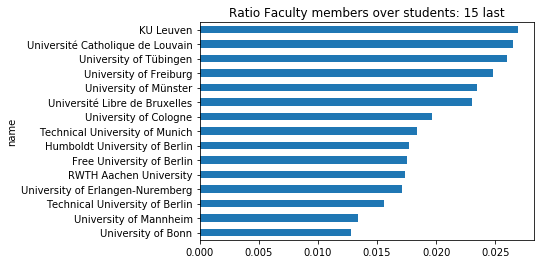

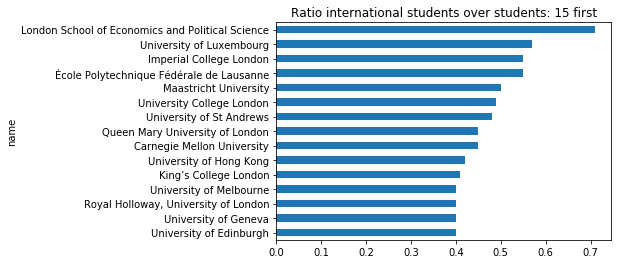

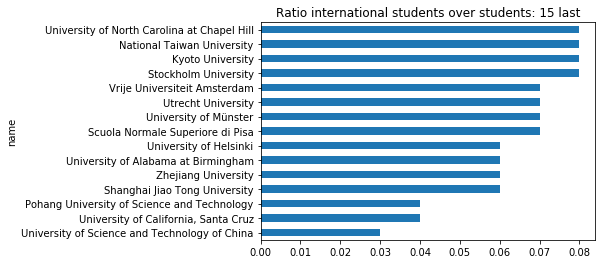

In [14]:
times_high_df[ratio_inter_students] = times_high_df['stats_pc_intl_students'].str.replace('%','').astype(int) / 100.0
times_high_df[stats_student_staff_ratio] = 1.0 / times_high_df[stats_student_staff_ratio].astype(float)

plot_ranks(times_high_df, 'stats_student_staff_ratio', 15, \
           'Ratio Faculty members over students', 'name','stats_student_staff_ratio') 

plot_ranks(times_high_df, ratio_inter_students, 15, \
           'Ratio international students over students', 'name', ratio_inter_students) 

In [15]:
times_high_df[students] = times_high_df['stats_number_students'].astype(str).str.replace(',','').astype(int)
times_high_df[inter_students] = np.round(times_high_df[students] * times_high_df[ratio_inter_students]).astype(int)
times_high_df[fac_members] = np.round(times_high_df[students] * times_high_df[stats_student_staff_ratio]).astype(int)

We drop some useless columns and rename others.

In [16]:
times_high_df_complete = times_high_df.drop(['stats_pc_intl_students', 'aliases', 'stats_number_students'], axis=1)
times_high_df_complete.rename(columns = {stats_student_staff_ratio: ratio_fac_students, 'location': country,'name': title_s}, inplace=True)

We don't have the region in this case, therefore we only group by country. 

We expect roughly the same results as with the other website, obviously.

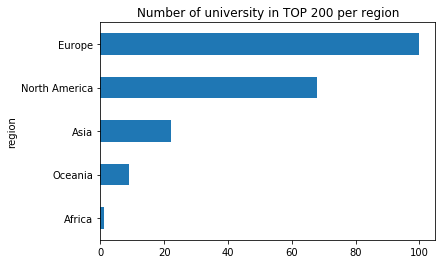

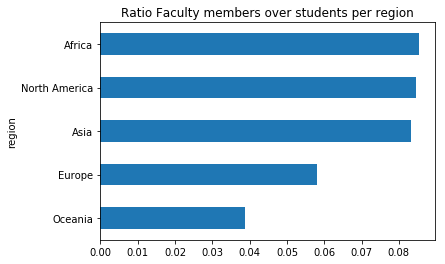

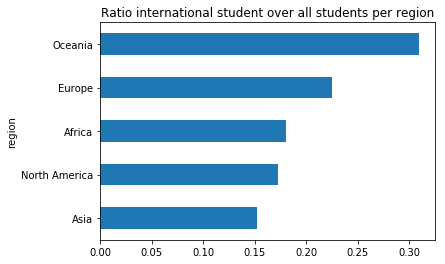

In [17]:
times_high_df_complete_region = times_high_df_complete.merge(top_uni_df_complete[['country', 'region']].drop_duplicates(), on='country', how='left')
times_high_df_complete_region.loc[times_high_df_complete_region.country == 'Luxembourg', 'region']='Europe'
times_high_df_complete_region.loc[times_high_df_complete_region.country == 'Russian Federation', 'region']='Asia'

times_high_df_complete_region = agg_by_and_calculate_ratio(times_high_df_complete_region, region, True)

plot_ranks(times_high_df_complete_region, 'nb_univ', -1, \
           'Number of university in TOP 200 per region', '','nb_univ') 

plot_ranks(times_high_df_complete_region, ratio_fac_students, -1, \
           'Ratio Faculty members over students per region', '','ratio_fac_students') 

plot_ranks(times_high_df_complete_region, ratio_inter_students, -1, \
           'Ratio international student over all students per region', '','ratio_inter_students') 

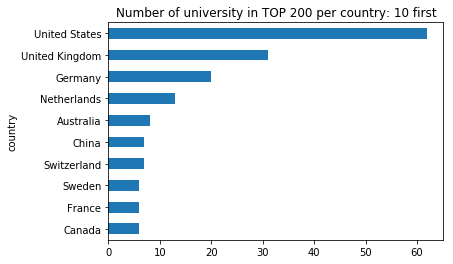

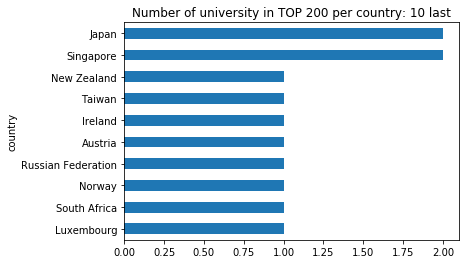

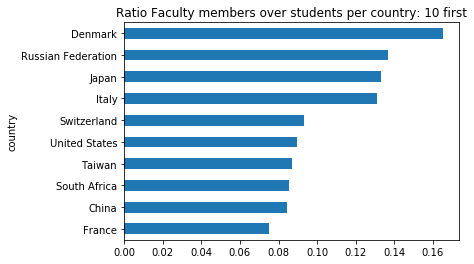

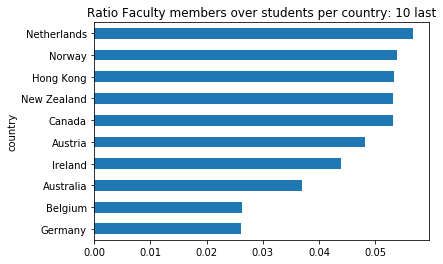

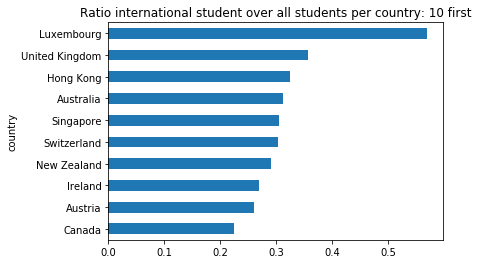

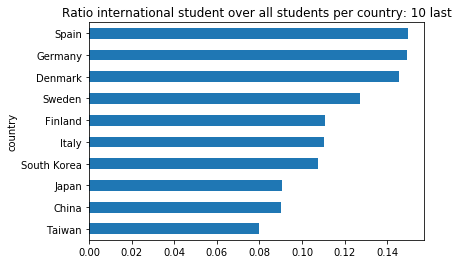

In [18]:
times_high_df_complete_country = agg_by_and_calculate_ratio(times_high_df_complete, country, True).sort_values(ratio_inter_students,ascending=False)

plot_ranks(times_high_df_complete_country, 'nb_univ', 10, \
           'Number of university in TOP 200 per country', '','nb_univ') 

plot_ranks(times_high_df_complete_country, ratio_fac_students, 10, \
           'Ratio Faculty members over students per country', '','ratio_fac_students') 

plot_ranks(times_high_df_complete_country, ratio_inter_students, 10, \
           'Ratio international student over all students per country', '','ratio_inter_students') 


The results are indeed somewhat the same (some places are swapped), except for Luxembourg being first. Indeed, Luxembourg wasn't on the first website, which explains why we didn't expect this country being first at all.

## Question 3

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.


We define a function to 'sanitize' a column and apply it to both dataframes.

We make both strings lowercase, remove common accents, translate some words (as a website stores the english name and the other the local name), remove words like "of, at, the" and "de", remove spaces and quotes.

We check by printing the difference of the outer and inner join if there are other patterns which make the names not match, apply it, check again, etc and do it iteratively.

In [19]:
def sanitize_column(c):
    return c.str.lower(). \
    str.replace('ä','a'). \
    str.replace('é','e'). \
    str.replace('freie','free'). \
    str.replace('universitat','university'). \
    str.replace('universitaet','university'). \
    str.replace('universidad', 'university'). \
    str.replace('universite','university'). \
    str.replace('technische','technical'). \
    str.replace(r'\(.*\)', ''). \
    str.replace('the ',''). \
    str.replace(' of ',''). \
    str.replace(' at ',''). \
    str.replace(' de ',''). \
    str.replace(r',|\.',''). \
    str.replace(' ',''). \
    str.replace('\'','’')

We prepare the two sets to be merged

In [20]:
top_uni_bef_merge = top_uni_df_complete.copy()
top_uni_bef_merge['original_name'] = top_uni_df_complete[title_s].copy()
top_uni_bef_merge[title_s] = sanitize_column(top_uni_bef_merge[title_s])

times_high_bef_merge = times_high_df_complete.copy()
times_high_bef_merge['original_name'] = times_high_df_complete[title_s].copy()
times_high_bef_merge[title_s] = sanitize_column(times_high_bef_merge[title_s])

We merged once with the inner way and once with outer. We then print everything that didn't match in the inner, sort and print it. It allows us to see which entries should match (but failed for reasons not captured by the previous sanitization).

In [21]:
inner_title_s = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='inner').sort_values(title_s)[title_s]
outer_title_s = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='outer').sort_values(title_s)[title_s]
list_ = list(set(outer_title_s)-set(inner_title_s))
list_.sort()
print(len(list_))
list_

108


['albert-ludwigs-universityfreiburg',
 'almamaterstudiorum-universitybologna',
 'arizonastateuniversity',
 'autonomousuniversitybarcelona',
 'casewesternreserveuniversity',
 'centralesupelec',
 'chalmersuniversitytechnology',
 'charite-universitysmedizinberlin',
 'eberhardkarlsuniversitytübingen',
 'ecolenormalesuperieureparis',
 'ethzurich-swissfederalinstitutetechnology',
 'ethzurich–swissfederalinstitutetechnologyzurich',
 'georgetownuniversity',
 'hanyanguniversity',
 'hebrewuniversityjerusalem',
 'heidelberguniversity',
 'hokkaidouniversity',
 'humboldt-universityzuberlin',
 'humboldtuniversityberlin',
 'indianauniversity',
 'indianinstitutesciencebangalore',
 'indianinstitutetechnologybombay',
 'indianinstitutetechnologydelhi',
 'institutotecnológicoyestudiossuperioresmonterrey',
 'kaist-koreaadvancedinstitutescience&technology',
 'karlsruheinstitutetechnology',
 'karolinskainstitute',
 'keiouniversitycemsmim',
 'kingfahduniversitypetroleum&minerals',
 'kitkarlsruheinstitutetechn

In [22]:

pd.set_option('display.max_rows', None)
#print(str(outer_title_s[outer_title_s.isin(list_)]))

# list of rows to match manually
to_merge = [[87, 214], [9, 200], [119, 205], [123, 206]]


outered_df = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='outer').sort_values(title_s).fillna(0)
merge_df = top_uni_bef_merge.merge(times_high_bef_merge, on=title_s, how='inner').sort_values(title_s)

for couple in to_merge:
    to_add = outered_df.loc[couple[0]].copy()
    to_add[10:] = outered_df.loc[couple[1], outered_df.columns[10:]]
    merge_df = merge_df.append(to_add, ignore_index=True)
                    
print(len(merge_df))                 

merge_df

150


,country_x,rank_x,region,University,fac_members_x,inter_fac_members,students_x,inter_students_x,ratio_fac_students_x,ratio_inter_students_x,...,original_name_x,country_y,rank_y,ratio_fac_students_y,ratio_inter_students_y,students_y,inter_students_y,fac_members_y,nb_univ_y,original_name_y
0,Finland,137.0,Europe,aaltouniversity,1257,370,12147,1831,0.103482,0.150737,...,Aalto University,Finland,190.0,0.049505,0.20,12744.0,2549.0,631.0,1.0,Aalto University
1,Denmark,119.0,Europe,aarhusuniversity,2316,602,26226,3762,0.0883093,0.143445,...,Aarhus University,Denmark,109.0,0.069930,0.12,25167.0,3020.0,1760.0,1.0,Aarhus University
2,Australia,20.0,Oceania,australiannationaluniversity,1600,927,14442,5551,0.110788,0.384365,...,The Australian National University,Australia,48.0,0.051813,0.35,15986.0,5595.0,828.0,1.0,Australian National University
3,United States,81.0,North America,bostonuniversity,3157,379,25662,7041,0.123022,0.274375,...,Boston University,United States,70.0,0.116279,0.25,24833.0,6208.0,2888.0,1.0,Boston University
4,United States,53.0,North America,brownuniversity,1303,379,9251,1825,0.14085,0.197276,...,Brown University,United States,50.0,0.093458,0.20,8898.0,1780.0,832.0,1.0,Brown University
5,United States,4.0,North America,californiainstitutetechnology,953,350,2255,647,0.422616,0.286918,...,California Institute of Technology (Caltech),United States,3.0,0.153846,0.27,2209.0,596.0,340.0,1.0,California Institute of Technology
6,United Kingdom,137.0,Europe,cardiffuniversity,2755,705,24565,6090,0.112151,0.247914,...,Cardiff University,United Kingdom,162.0,0.074074,0.26,24186.0,6288.0,1792.0,1.0,Cardiff University
7,United States,47.0,North America,carnegiemellonuniversity,1342,425,13356,6385,0.100479,0.478062,...,Carnegie Mellon University,United States,24.0,0.074074,0.45,12676.0,5704.0,939.0,1.0,Carnegie Mellon University
8,Hong Kong,46.0,Asia,chineseuniversityhongkong,2208,1074,18037,4824,0.122415,0.26745,...,The Chinese University of Hong Kong (CUHK),Hong Kong,58.0,0.057803,0.31,18072.0,5602.0,1045.0,1.0,Chinese University of Hong Kong
9,Hong Kong,49.0,Asia,cityuniversityhongkong,1349,1027,9240,3273,0.145996,0.354221,...,City University of Hong Kong,Hong Kong,119.0,0.089286,0.35,9240.0,3234.0,825.0,1.0,City University of Hong Kong


Last thing, when we display the type of the columns, most of the floats ones are object type.

In [23]:
merge_df.dtypes

country_x                  object
rank_x                    float64
region                     object
University                 object
fac_members_x              object
inter_fac_members          object
students_x                 object
inter_students_x           object
ratio_fac_students_x       object
ratio_inter_students_x     object
nb_univ_x                 float64
original_name_x            object
country_y                  object
rank_y                    float64
ratio_fac_students_y      float64
ratio_inter_students_y    float64
students_y                float64
inter_students_y          float64
fac_members_y             float64
nb_univ_y                 float64
original_name_y            object
dtype: object

It doesn't make sense, and for the next questions, we will need float values.

In [24]:
columns_to_change_type = ['fac_members_x','inter_fac_members','students_x',
                          'inter_students_x','ratio_fac_students_x', 'ratio_inter_students_x']

for col in columns_to_change_type:
    merge_df[col] = merge_df[col].astype(float64)

## Question 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

Before doing anything with the complete merged dataframe, let's see if we can find strong correlation for both website alone.

In [25]:
top_uni_columns = ['fac_members_x','inter_fac_members','students_x',
                          'inter_students_x', 'ratio_fac_students_x','ratio_inter_students_x']

merge_df[top_uni_columns].corrwith(merge_df['rank_x'])

fac_members_x            -0.351218
inter_fac_members        -0.503712
students_x               -0.006086
inter_students_x         -0.229774
ratio_fac_students_x     -0.400986
ratio_inter_students_x   -0.299778
dtype: float64

It doesn't look like we have any interesting correlation in this first case.
The rank doesn't look like it's influenced by the number of students, the correlation being almost zero. Note that all the correlation are negative, which could mean that the bigger the rank, the less the ratio or the international students for example. However, the correlation are quite weak, except the number of international students with medium correlation.

In [26]:
times_high_columns = ['fac_members_y','students_y',
                          'inter_students_y','ratio_fac_students_y',
                          'ratio_inter_students_y']

merge_df[times_high_columns].corrwith(merge_df['rank_y'])

fac_members_y            -0.216473
students_y               -0.135974
inter_students_y         -0.258810
ratio_fac_students_y     -0.117911
ratio_inter_students_y   -0.180049
dtype: float64

Now with the times high rank it's even weaker. 
The number of students doesn't really look correlated at all again, but none of the columns look better.

### Conclusion

Perhaps, we could notice that all correlations are negative, which "could" mean that the higher the different columns (ratio, number of international students, ...), the lower the rank (a low rank being better). The highest correlation is with the inter_fac_members for top_uni ranking, however with a 0.5, it's still a weak correlation, and we won't make dangerous assumptions.

In general, this kind of ranking is done by aggregating/suming multiple factors (papers in a year, won prices, ...), which means that trying to get interesting correlation with only one value is pointless. More of that, you can't try to add the different values, as some could have a different weight than the others (you put a factor 2 for one, a 0.25 for another), which could again lead to wrong assumptions.

In conclusion, no useful insight can be given, except the one that we can't give meaningful insight (with this datas only though).


## Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.


Again, you can argue about which method is better than the others, but the answer is that there isn't any. 

Here, we are simply going to take the mean between the two rankings, and take the lowest one. In case of tie, we will remove the ones which are lowest in ranking, e.g.:

uni1 rank1 = 1, rank2 = 5, mean = 2.5, lowest = 5 => lose

uni2 rank1 = 3, rank2 = 2, mean = 2.5, lowest = 3 => win

However, if two bests are just flipped from one ranking to the other, we will called them both winner of university ranking contest.



In [27]:
final_df = merge_df[['original_name_y','rank_x','rank_y']].copy()
final_df['mean_rank'] = final_df.mean(axis=1, numeric_only=True)
final_df.sort_values('mean_rank')

,original_name_y,rank_x,rank_y,mean_rank
65,Stanford University,2.0,3.0,2.5
41,Massachusetts Institute of Technology,1.0,5.0,3.0
118,University of Oxford,6.0,1.0,3.5
89,University of Cambridge,5.0,2.0,3.5
5,California Institute of Technology,4.0,3.0,3.5
26,Harvard University,3.0,6.0,4.5
29,Imperial College London,8.0,8.0,8.0
92,University of Chicago,9.0,9.0,9.0
57,Princeton University,13.0,7.0,10.0
147,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10.0,10.0


Stanford University is the best university following our model to compute the best university.